# Solar-System15-Mixed-Precision

<ul id="top">
<li><a href="#Load-packages"> 
             Load Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li> 

<li><a href="#Initial-value-problem:-Solar-System15">
              Initial value problem: Solar-System15</a></li>

<li><a href="#Ode-problem">
             Ode problem</a></li>
 
<li><a href="#Error-in-energy">
             Error in energy</a></li> 

<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 

</ul>  

## Load packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using RecursiveArrayTools
using JLD2, FileIO

┌ Info: Precompiling IRKGaussLegendre [58bc7355-f626-4c51-96f2-1f8a038f95a2]
└ @ Base loading.jl:1273


In [2]:
setprecision(BigFloat, 108);

In [3]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [3]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [5]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: Solar-System15

In [5]:
include("../examples/Nbody.jl")
include("../examples/InitialNBody15.jl")
u0128, Gm128 =InitialNBody15(BigFloat)

q0128=u0128[2,:,:]
v0128=u0128[1,:,:]

dt=5
t0=0.0
t1=20*dt    #20, 1000.
mysaveat=1  #10

tspan128=(BigFloat(t0),BigFloat(t1))
prob128=ODEProblem(NbodyODE!,u0128,tspan128,Gm128);

In [6]:
u064, Gm64 =InitialNBody15(Float64)
lpp=Gm64;
tspan128

(0.0, 100.0)

<a href="#top">Back to the top</a>

## Ode problem

### Test solution

In [7]:
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp);
#sol =solve(prob128,Vern9(),saveat=mysaveat,abstol=1e-24,reltol=1e-24,maxiters=100000);
#@save "./Data/solarsystem15small_test_solF128.jld2" sol
@load "./Data/solarsystem15small_test_solF128.jld2" sol
test_sol = TestSolution(sol);

### IRKGL16 (Fixed-Step)

In [10]:
(sol1,iters1,steps1) =solve(prob128,IRKGL16(),dt=dt,saveat=mysaveat,adaptive=false,myoutputs=true,
                             mixed_precision=false);
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  3411
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          20
Number of rejected steps:                          0

In [11]:
mean(iters1)

22.38095238095238

In [8]:
(sol2,iters2,steps2) = solve(prob128,IRKGL16(),dt=dt,saveat=mysaveat,adaptive=false,myoutputs=true,
                             mixed_precision=true, low_prec_type=Float64);
sol2.destats

***************************************************
urratsa=1
1,high-=1,0,0.4232449465403114507272413254244516
1,high-=2,0,0.04052449883109784508339464785465009
1,high-=3,0,7.684085969737308131835536620698319e-05
1,high-=4,0,6.224561316378077166175560253033133e-10
1,high-=5,0,1.241879912443253605002943680403329e-19
1,high-=6,620,1.202984517593276753293045523548368e-28
1,high-=7,717,1.083335593717820167343987592704022e-34
1,high-=8,720,0.0
***************************************************
urratsa=2
2,high-=1,0,2.113629835451496983508668239522493e-06
2,high-=2,0,5.591842993513444633825978196007547e-07
2,high-=3,0,6.718835630756708847842418246841355e-11
2,high-=4,0,4.134553370990203515191660760674272e-17
2,high-=5,343,1.000986156288399520769442680308438e-26
2,high-=6,704,1.498325860050280748597105213989255e-33
2,high-=7,718,1.361838123766444824837096281396382e-34
2,high-=8,719,3.851859888774471706111955885169855e-34
2,high-=9,720,0.0
***************************************************
u

19,high-=6,705,1.615972792036766128916518899978863e-33
19,high-=7,716,3.045162619092542562391275371821968e-34
19,high-=8,719,1.925929944387235853055977942584927e-34
19,high-=9,720,0.0
***************************************************
urratsa=20
20,high-=1,0,3.387875836985207439430208731087923e-06
20,high-=2,0,9.23219860637915167181033851219187e-07
20,high-=3,0,1.130115468278951358799110660452385e-10
20,high-=4,0,2.862324845195762074012199977615521e-17
20,high-=5,350,6.335509258595834542332024702735825e-27
20,high-=6,709,1.947624926041698942730742471187239e-33
20,high-=7,717,1.887018257638204339560653512016249e-33
20,high-=8,719,9.629649721936179265279889712924637e-35
20,high-=9,719,7.703719777548943412223911770339709e-34
20,high-=10,720,0.0


DiffEqBase.DEStats
Number of function 1 evaluations:                  1090
Number of function 2 evaluations:                  9240
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          20
Number of rejected steps:                          0

In [9]:
mean(iters2)

8.571428571428571

<a href="#top">Back to the top</a>

## DynamicalProblem

In [14]:
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128,;lpp=lpp);

### IRKGL16 (Fixed-Step)

In [15]:
#(sol11,iters11,steps11) =solve(probdyn128,IRKGL163(),dt=dt,saveat=mysaveat,adaptive=false,myoutputs=true,
#              mixed_precision=false);
#sol11.destats

In [16]:
#mean(iters11)

In [17]:
# barne iterazioak : lmax=min(lmax+1,4)
#(sol12,iters12,steps12) = solve(probdyn128,IRKGL163(),dt=dt,saveat=mysaveat,adaptive=false,myoutputs=true,
#                                mixed_precision=true, low_prec_type=Float64);
#sol12.destats

In [18]:
#mean(iters12)

In [19]:
# barne iterazioak : lmax=min(lmax+1,2)
#(sol13,iters13,steps13) = solve(probdyn128,IRKGL163(),dt=dt,saveat=mysaveat,adaptive=false,myoutputs=true,
#                                mixed_precision=true, low_prec_type=Float64);
#sol13.destats

In [20]:
#mean(iters13)

<a href="#top">Back to the top</a>

## Error in energy

In [21]:
setprecision(BigFloat, 256)
u0128, Gm128 =InitialNBody15(BigFloat)
E0=NbodyEnergy(u0128,Gm128)

ΔE = map(x->NbodyEnergy(BigFloat.(x),Gm128), sol.u)./E0.-1
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm128), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm128), sol2.u)./E0.-1
#ΔE11 = map(x->NbodyEnergy2(BigFloat.(x),Gm128), sol11.u)./E0.-1
#ΔE12 = map(x->NbodyEnergy2(BigFloat.(x),Gm128), sol12.u)./E0.-1

(Float32(maximum(abs.(ΔE))),Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE2))))

(1.2841041f-27, 2.5345949f-21, 2.5345949f-21)

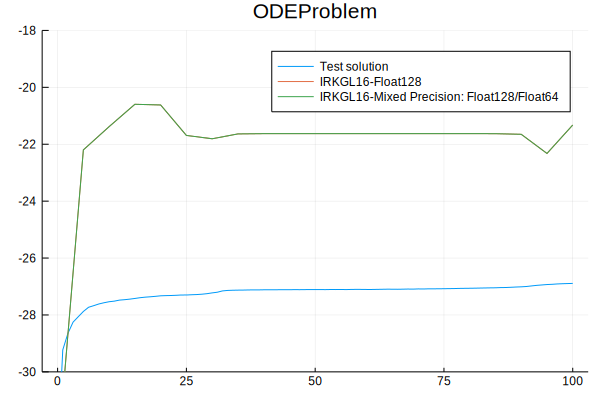

In [22]:
ylimit1=-30
ylimit2=-18
plot(sol.t,log10.(abs.(ΔE)), label="Test solution", title="ODEProblem",
    ylims=(ylimit1,ylimit2),)
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-Float128",
     ylims=(ylimit1,ylimit2),)
plot!(sol2.t,log10.(abs.(ΔE2)), label="IRKGL16-Mixed Precision: Float128/Float64",
     ylims=(ylimit1,ylimit2),)

In [23]:
#ylimit1=-30
#ylimit2=-18
#plot(sol.t,log10.(abs.(ΔE)), label="Test solution", title="DynamicalProblem",
#    ylims=(ylimit1,ylimit2),)
#plot!(sol1.t,log10.(abs.(ΔE11)), label="IRKGL16-Float128",
#     ylims=(ylimit1,ylimit2),)
#plot!(sol2.t,log10.(abs.(ΔE12)), label="IRKGL16-Mixed Precision: Float128/Float64",
#     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Work-Precision diagrams

In [24]:
setprecision(BigFloat, 108)

108

In [25]:
Threads.nthreads()

1

In [26]:
abstols = 1.0 ./ 10.0 .^ (8:18)
reltols = 1.0 ./ 10.0 .^ (8:18)
dts=16*0.866.^(0:length(reltols)-1)

11-element Array{Float64,1}:
 16.0               
 13.856             
 11.999296          
 10.391390335999999 
  8.998944030976    
  7.793085530825215 
  6.748812069694637 
  5.8444712523555555
  5.061312104539911 
  4.383096282531563 
  3.7957613806723334

### OdeProblem

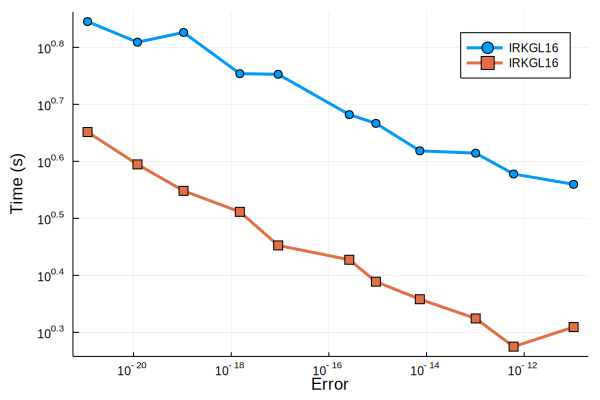

In [27]:
setups = [ Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64)
]
wp1 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=1000000)
plot(wp1)

### Dynamical Problem

In [29]:
#ux=sol.u[end]
#solx=ArrayPartition(ux[2,:,:],ux[1,:,:])
#test_solx = TestSolution(tspan128,[solx]);

In [30]:
#setups = [ Dict(:alg=>IRKGL163(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
#           Dict(:alg=>IRKGL163(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64)
#]
#wp2 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=1000000)
#plot(wp2)

In [31]:
#setups = [ Dict(:alg=>IRKGL163(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
#           Dict(:alg=>IRKGL163(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64)
#]
#wp3 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=1000000)
#plot(wp3)

<a href="#top">Back to the top</a>